In [141]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import talib

from Agent import Agent

import pickle
import glob
import os

In [142]:
ticker = '0688.HK'
if os.path.isdir('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/' % (ticker)) == False:
    os.mkdir('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/' % (ticker))
    print ('No such ticker record, made a directory.')

In [143]:
def prepare_dataset(close):
    """
    Function prepare_dataset to generate input data and trading strategy from stock close prices
    """

    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    # Cancel NaN values
    macdhist = macdhist[~np.isnan(macdhist)]
    macd = macd[-len(macdhist):]
    macdsignal = macdsignal[-len(macdhist):]

    # Scaling features to a range [0, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    macdhist_norm = min_max_scaler.fit_transform(np.expand_dims(macdhist, axis=1))

    # Implement strategy
    start_sell = 0.2
    stop_sell = 0.1
    start_buy = -0.2
    stop_buy = -0.1

    y = np.full(len(macdhist), np.nan)
    y[0] = 0
    y[-1] = 0
    
    for i in range(1, len(macdhist) - 1):
#         if y[i-1] == 0:
#             if (macdhist_norm[i] >= start_sell):
#                 # Enter sell position
#                 y[i] = -1
#             elif (macdhist_norm[i] <= start_buy):
#                 # Enter buy position
#                 y[i] = 1
#             else:
#                 y[i] = 0
#         elif y[i-1] == -1:
#             if macdhist_norm[i] > stop_sell:
#                 # Stay in sell position
#                 y[i] = -1
#             else:
#                 # Leave sell position
#                 y[i] = 0
#         else:
#             if macdhist_norm[i] < stop_buy:
#                 # Stay in buy position
#                 y[i] = 1
#             else:
#                 # Leave buy position
#                 y[i] = 0
        if close[i+1]/close[i] - 1 > 0.005:
            y[i] = 1
        elif close[i+1]/close[i] - 1 < -0.005:
            y[i] = -1
        else:
            y[i] = 0
            
    # Plot strategy
    dates = np.arange(len(macdhist))
    plt.plot(dates, y,'g', label='Strategy Positions')
    plt.bar(dates, macdhist_norm[:, 0], width=1, color='blue', label='MACD histogram')
    plt.plot(dates, start_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, start_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.xlabel('Days')
    plt.xlim((300, 600))
    plt.legend()
#     plt.savefig('images/AAL_macd.png', bbox_inches='tight')
    plt.show()
    
    # Generate input data - technical indicators
    ind1 = talib.MIDPOINT(close)    # Overlap: MidPoint over period
    ind2 = talib.HT_DCPERIOD(close) # Cycle Indicator Functions:  Hilbert Transform - Dominant Cycle Period
    ind3 = talib.MAX(close)         # Math Operator: Highest value over a specified period
    ind4 = talib.SIN(close)         # Math Transform: Vector Trigonometric Sin
    ind5 = talib.APO(close)         # Momentum: Absolute Price Oscillator

    x = np.vstack((macdhist, macd, macdsignal, ind1[-len(macdhist):], ind2[-len(macdhist):],
                   ind3[-len(macdhist):], ind4[-len(macdhist):], ind5[-len(macdhist):]))
    x = x.T

    return x, y


In [144]:
close = pd.read_csv('../data/raw/%s.csv' % (ticker), names = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']).query('Volume != 0').reset_index(drop=True)

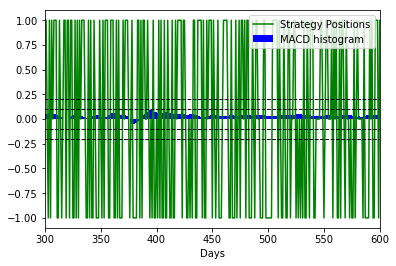

In [145]:
# Implement MACD trading strategy
X, y = prepare_dataset(np.array(close['Close']))

In [146]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [147]:
# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pickle.dump(scaler, open('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/scaler.pkl' % (ticker), 'wb'))

In [148]:
# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

pickle.dump(le, open('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/encoder.pkl' % (ticker), 'wb'))

print(le.classes_)

from collections import Counter
Counter(y)

[-1.  0.  1.]


Counter({-1.0: 2011, 0.0: 980, 1.0: 1945})

In [149]:
## Create and train the Agent
# Variable definiton
episodes = 10000
look_back = 30
batch_size = 32
action_size = len(le.classes_)
n_features = X_train.shape[1]

In [164]:
# Create Agent
agent = Agent(look_back, action_size, n_features)

In [183]:
def run(agent, dataX, dataY, episodes, look_back):
    """
    Function run to train the agent
    """
    
    # Length of dataset
    times = len(dataX)

    # List of total rewards
    
    if os.path.isfile('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint_total_reward.txt' % (ticker)):
        total_reward_list = list(np.loadtxt('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint_total_reward.txt' % (ticker)))
    else:
        total_reward_list = []
        last_episodes = 0
        
    ckpt_h5 = glob.glob('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint*.h5' % (ticker))
    if ckpt_h5 == []:
        reward_last_ck = 0
    else:
        res = [int(sub.split('robot_checkpoint')[1].split('.h5')[0]) for sub in ckpt_h5] 
        max_check = np.array(res).max()
        total_reward_list = total_reward_list[:max_check]
        last_episodes = len(total_reward_list)
        
        reward_last_ck = total_reward_list[max_check-1]
        agent.model.load_weights('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint%s.h5' % (ticker, max_check))
        agent.epsilon = pickle.load(open('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint%s_epsilon.pickle' % (ticker, max_check), 'rb'))
        print ('Model loaded')
    
    print ('Training Start from: ')
    print ('=' * 20)
    print ('Last Episodes: ' + str(last_episodes))
    print ('Last Reward. : ' + str(reward_last_ck))
    
    try:
        for ep in range(last_episodes, episodes):

            # print('Episode: ' + str(ep))

            # Initial state and position
            state = dataX[:look_back, :][np.newaxis, :, :]
            pos = dataY[look_back - 1]

            done = False
            total_reward = 0

            for t in range(1, times - look_back + 1):

                # Predict action based on the current state
                action = agent.act(state)

                # Calculate reward
                if action == pos != 1:   # 0:-1      1:0     2:1
                    reward = +1
                
                elif action == pos == 1:   # 0:-1      1:0     2:1
                    reward = -0.1
                
                elif (pos == 0 or pos == 2):
                    if action == 1:
                        reward = 0
                    else:
                        reward = -1
                else:
                    reward = -1

                total_reward += reward

                # Final state
                if t == times - look_back:
                    done = True

                # Receive next state and position
                next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
                next_pos = dataY[t + look_back - 1]

                # Remember current experience
                agent.remember(state, action, reward, next_state, done)

                # Make next_state the new current state; the same for pos
                state = next_state
                pos = next_pos

                if done:
                    print('Episode: %i ---> Total Reward: %i' %(ep +1, total_reward))
                    total_reward_list.append(total_reward)

                # Train the agent with previous experiences
                if len(agent.memory) > batch_size:
                    agent.replay(batch_size)
                    
            if (ep + 1) % 5 == 0 and ep > 0 and total_reward > reward_last_ck:
                file = '/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint' % (ticker) + str(ep + 1)
                # Serialize weights to HDF5
                agent.model.save_weights(file + ".h5")
                # Save epsilon
                pickle.dump(agent.epsilon, open(file + "_epsilon.pickle", "wb"))
                reward_last_ck = total_reward
                
                # Early Stop
#                 if (total_reward_list[-1] < np.array(total_reward_list[- 10 -1:-1]).max()) and (np.var(np.array(total_reward_list[-10:])) < 500):
#                     print ('Training stopped in episode: ', ep + 1)
#                     break
    except KeyboardInterrupt:
        print ('Manually Stopped.')
    finally:
        # Save list of rewards along the epochs
        np.savetxt('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint_total_reward.txt' % (ticker), total_reward_list)

    return


In [184]:
# Train Agent
run(agent, X_train, y_train, episodes, look_back)

Model loaded
Training Start from: 
Last Episodes: 365
Last Reward. : 1365.7000000000035
Episode: 366 ---> Total Reward: 1352
Episode: 367 ---> Total Reward: 1327
Episode: 368 ---> Total Reward: 1371
Episode: 369 ---> Total Reward: 1293
Episode: 370 ---> Total Reward: 1402
Episode: 371 ---> Total Reward: 1224
Episode: 372 ---> Total Reward: 1390
Episode: 373 ---> Total Reward: 1322
Episode: 374 ---> Total Reward: 1383
Episode: 375 ---> Total Reward: 1250
Episode: 376 ---> Total Reward: 1276
Episode: 377 ---> Total Reward: 1186
Episode: 378 ---> Total Reward: 1383
Episode: 379 ---> Total Reward: 1345
Episode: 380 ---> Total Reward: 1342
Episode: 381 ---> Total Reward: 1339
Episode: 382 ---> Total Reward: 1419
Episode: 383 ---> Total Reward: 1313
Episode: 384 ---> Total Reward: 1378
Episode: 385 ---> Total Reward: 1408
Episode: 386 ---> Total Reward: 1356
Episode: 387 ---> Total Reward: 1389
Episode: 388 ---> Total Reward: 1358
Episode: 389 ---> Total Reward: 1382
Episode: 390 ---> Total 

In [171]:
np.savetxt('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint_total_reward.txt' % (ticker), total_reward_list[:-13])

In [196]:
import sys

In [197]:
sys.path

['',
 '/Users/marsliu/anaconda3/envs/py35/lib/python35.zip',
 '/Users/marsliu/anaconda3/envs/py35/lib/python3.5',
 '/Users/marsliu/anaconda3/envs/py35/lib/python3.5/plat-darwin',
 '/Users/marsliu/anaconda3/envs/py35/lib/python3.5/lib-dynload',
 '/Users/marsliu/anaconda3/envs/py35/lib/python3.5/site-packages',
 '/Users/marsliu/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/extensions',
 '/Users/marsliu/.ipython']

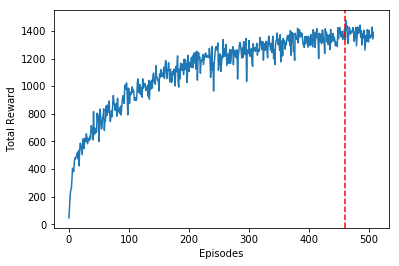

In [192]:
# Load rewards
total_reward_list = np.loadtxt('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint_total_reward.txt' % (ticker))
ckpt_h5 = glob.glob('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint*.h5' % (ticker))
res = [int(sub.split('robot_checkpoint')[1].split('.h5')[0]) for sub in ckpt_h5] 
max_check = np.array(res).max()

# Plot
plt.figure()
plt.plot(total_reward_list)
plt.axvline(max_check, color = 'r', ls='--')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [112]:
def evaluate(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):
#         print (state[t][0])
        # Predict action based on the current state
        action = agent.act(state)
#         print (pos)
        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        elif (pos == 0 or pos == 2):
            if action == 1:
                reward = 0
            else:
                reward = -1
        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)

    return np.array(pos_list)


In [166]:
# X_test
y_pred_test = evaluate(agent, X_test[:-1], y_test[:-1], look_back)



Total Reward: 286


In [43]:
len(X_test[:-1]) - look_back ## 957

957

In [40]:
y_pred_test = evaluate_and_training(agent, X_test[:-1], y_test[:-1], look_back)
y_pred_test = evaluate_and_training(agent, X_test[:-1], y_test[:-1], look_back)



Total Reward: -107
Total Reward: -111


In [20]:
agent.act(X_test[-look_back:,:][np.newaxis, :, :])

1

In [115]:
# Evaluate the model
# Make predictions
# y_pred_test = evaluate(agent_deploy, X_test, y_test, look_back)

# Calculate and print accuracy
acc = accuracy_score(y_test[look_back-1:-2], y_pred_test)
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-2], y_pred_test, average=None)


print('Accuracy: %.2f %% %.2f %%' % (p[0]*100, p[-1]*100))

Accuracy: 60.15 % 65.03 %


In [92]:
# Calculate and print precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-1], y_pred_test, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

print(results.round(decimals=3))

   1-Precision  2-Recall  3-F1 score  4-Support
0        0.770     0.529       0.627        361
1        0.390     0.695       0.499        275
2        0.749     0.511       0.607        321


In [80]:
# Decodificate labels
y_true_test = le.inverse_transform(y_test[look_back-1:-1])
y_pred_test = le.inverse_transform(y_pred_test)

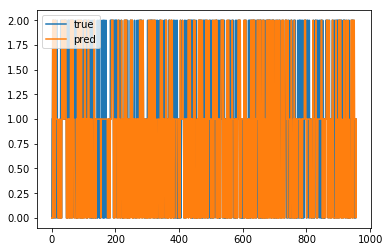

In [57]:
# Plot strategy
plt.figure()
plt.plot(y_true_test, label='true')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()

In [116]:
agent.act(X_test[-look_back:,:][np.newaxis, :, :])

0

# For deploy model script

In [8]:
ticker = '0688.HK'

In [26]:
scaler = pickle.load(open('../models/Q-Learning/%s/checkpoints/scaler.pkl' % (ticker), 'rb'))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
le = pickle.load(open('../models/Q-Learning/%s/checkpoints/encoder.pkl' % (ticker), 'rb'))
y_train = le.transform(y_train)
y_test = le.transform(y_test)


In [37]:
X_test_last2 = close.iloc[-1]

In [39]:
(X_test_last2 == X_test_last).all() == False and X_test_last2.Date >= X_test_last.Date

True

In [36]:
close = pd.read_csv('../data/raw/0688.HK.csv', names = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']).query('Volume != 0').reset_index(drop=True)

In [32]:
import time
# time.sleep(5)

In [ ]:


while True:
    df = pd.read_csv('../data/raw/0688.HK.csv', names = ['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']).query('Volume != 0').reset_index(drop=True)
    

In [165]:
agent = Agent(look_back, action_size, n_features)
agent.model.load_weights('../models/Q-Learning/0688.HK/checkpoints/robot_checkpoint235.h5')

agent.epsilon = pickle.load(open('../models/Q-Learning/0688.HK/checkpoints/robot_checkpoint235_epsilon.pickle', 'rb'))

In [42]:
import os.path

if os.path.isfile('../models/Q-Learning/0688.HK/deploy/deploy.h5'):
    print ("File exist")
else:
    print ("File not exist")

File exist


In [18]:
def evaluate_and_training(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):
#         print (state[t][0])
        # Predict action based on the current state
        action = agent.act(state)
#         print (pos)6
        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        elif (pos == 0 or pos == 2):
            if action == 1:
                reward = 0
            else:
                reward = -1
        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)
            
        if len(agent.memory) > batch_size:
                agent.replay(batch_size, random = False)
                
    return np.array(pos_list)


In [126]:
import shutil
ticker = '0688.HK'

ckpt_h5 = glob.glob('/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint*.h5' % (ticker))
res = [int(sub.split('robot_checkpoint')[1].split('.h5')[0]) for sub in ckpt_h5]
max_check = np.array(res).max()
source1 = "/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint%s.h5" % (ticker, max_check)
source2 = "/Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/robot_checkpoint%s_epsilon.pickle" % (ticker, max_check)

destination1 = '../models/Q-Learning/%s/deploy/deploy.h5' % (ticker)
destination2 = '../models/Q-Learning/%s/deploy/deploy_epsilon.pickle' % (ticker)
shutil.copyfile(source1, destination1)
shutil.copyfile(source2, destination2)


# ../models/Q-Learning/%s/deploy/deploy.h5

# /Volumes/LaCie/Trading System Database/Robort (Q-Learning)/%s/checkpoints/
# source = "/home/User/Documents/file.txt"

'../models/Q-Learning/0688.HK/deploy/deploy_epsilon.pickle'